# PyTorch Hypercolumn CNN  for Zurich Dataset

In [1]:
# import libraries
import pandas as pd
import os, sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import metrics
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from helpers.data_loader import ZurichLoader
from helpers.helpers import *
from hypercolumn import HyperColumn

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
base_dir = '/raid/home/cwendl'  # for guanabana
root_dir = base_dir + '/SIE-Master/Zurich'
patch_size = 64
class_to_remove = 1

# load data
dataset_train = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=patch_size, transform='augment', 
                             random_crop=True, class_to_remove=class_to_remove)

dataset_val = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=patch_size, 
                           class_to_remove=class_to_remove)

dataset_test = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=patch_size, 
                            class_to_remove=class_to_remove)

dataloader_train = DataLoader(dataset_train, batch_size=100, shuffle=True, num_workers=20)
dataloader_val = DataLoader(dataset_val, batch_size=100, shuffle=False, num_workers=20)
dataloader_test = DataLoader(dataset_test, batch_size=100, shuffle=False, num_workers=20)

In [3]:
def acc_with_filt(y_true, y_pred, label_to_ignore):
    """
    get accuracy ignoring a label in y_true
    :param y_true: ground truth (tensor)
    :param y_pred: predicted label (tensor)
    :param label_to_ignore: label to ignore
    :return: accuracy
    """
    y_true = y_true.numpy().flatten()
    y_pred = y_pred.numpy().flatten()
    filt = y_true != label_to_ignore
    return np.sum(np.equal(y_pred[filt], y_true[filt]))/len(y_true[filt])


def test(model, f_loss, dataloader, name, verbosity=False):
    with torch.no_grad():
        model.eval()
        loss = 0
        acc = []  # average accuracy
        for i_batch, (im, gt) in enumerate(dataloader):
            im = im.cuda()
            gt = gt.cuda()
            output = model(im)
            loss += f_loss(output, gt).cpu()
            _, pred = output.cpu().max(1, keepdim=True)
            acc.append(acc_with_filt(gt.cpu(), pred.cpu(), 0))

        loss /= len(dataloader.dataset)
        acc = np.mean(acc)
        if verbosity>0:
            print(name + ' set: Average loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(loss, acc * 100))
        return acc, loss

def predict(model, dataloader_pred):
    with torch.no_grad():
        model.eval()
        test_pred = torch.LongTensor()
        for i_batch, (im, gt) in enumerate(dataloader_pred):
            im = im.cuda()
            gt = gt.cuda()
            output = model(im)
            _, pred = output.cpu().max(1, keepdim=False)
            test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred.numpy()


def train(model, dataloader_train, dataloader_val, epochs, verbosity=0, plot=False):
    """
    Train a model for a given number of epochs
    :param model: Model to train
    :param dataloader_train: dataloader for training data
    :param dataloader_val: dataloader for test data
    :param epochs: number of epochs to train
    :param verbosity: verbosity level of status messages
    :return:
    """
    opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    #weights = torch.from_numpy(dataloader_train.dataset.weights).float().cuda()
    f_loss = nn.CrossEntropyLoss(ignore_index=0)  # weight=weights,
    model.train()
    acc_tr_hist, acc_val_hist = [], []
    loss_tr_hist, loss_val_hist = [], []
    for epoch in range(epochs):
        # validation
        av_loss = 0

        for i_batch, (im, gt) in (tqdm(enumerate(dataloader_train)) if verbosity>1 else enumerate(dataloader_train)):
            im = im.cuda()
            gt = gt.cuda()
            opt.zero_grad()
            output = model(im)
            loss_out = f_loss(output, gt)
            av_loss += loss_out.cpu().detach().numpy()
            loss_out.backward()
            opt.step()

            if not i_batch % 100 and verbosity > 1:
                tqdm.write("Average loss: {:.2f}".format(av_loss/(i_batch+1)))
                
        if verbosity>0:
            print("Epoch %i:" % epoch)
        acc_tr, loss_tr = test(model, f_loss, dataloader_train, 'Train', verbosity=verbosity)
        acc_val, loss_val = test(model, f_loss, dataloader_val, 'Val', verbosity=verbosity)
        acc_tr_hist.append(acc_tr)
        acc_val_hist.append(acc_val)
        loss_tr_hist.append(loss_tr)
        loss_val_hist.append(loss_val)
        if plot:
            # plot accuracy history
            fig, ax = plt.subplots(1,1)
            ax.plot(np.arange(epoch+1), acc_tr_hist)
            ax.plot(np.arange(epoch+1), acc_val_hist)
            ax.set_xlabel("Epochs")
            ax.set_ylabel("OA")
            ax.set_ylim([0,1])
            ax.grid(alpha=.3)
            fig.axes[0].spines['right'].set_visible(False)
            fig.axes[0].spines['top'].set_visible(False)
            ax.legend(['Training Set', 'Validation Set'])
            plt.savefig('Figures/hist_train_all_acc.pdf')
            plt.close()
            
            # plot loss history
            fig, ax = plt.subplots(1,1)
            ax.plot(np.arange(epoch+1), loss_tr_hist)
            ax.plot(np.arange(epoch+1), loss_val_hist)
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Loss")
            ax.grid(alpha=.3)
            fig.axes[0].spines['right'].set_visible(False)
            fig.axes[0].spines['top'].set_visible(False)
            ax.legend(['Training Set','Validation Set'])
            plt.savefig('Figures/hist_train_all_loss.pdf')
            plt.close()

In [4]:
train_bool = False

model = HyperColumn(in_dim=4, out_dim=9, n_filters=32, patch_size=patch_size).cuda()
if train_bool:
    # Train network from scratch
    train(model, dataloader_train, dataloader_val, epochs=50, verbosity=1, plot=True)
    
    # save model
    state = {'model': model.state_dict(), 
             'n_epochs': 50,
             'loss_tr':0.
            }
    
    torch.save(state, 'models/model_wo_cl_' + str(class_to_remove) + '.pytorch')

else:  # load saved model
    state = torch.load('models/model_wo_cl_' + str(class_to_remove) + '.pytorch')
    model.load_state_dict(state['model'])

In [5]:
def predict_softmax(model, dataloader_pred):
    with torch.no_grad():
        model.eval()
        pred = torch.FloatTensor()  # softmax activations
        for i_batch, (im, gt) in tqdm(enumerate(dataloader_pred)):
            im = im.cuda()
            gt = gt.cuda()
            output = model(im)
            pred = torch.cat((pred, output.cpu()), dim=0)
            
    pred = pred.numpy()
    pred = np.transpose(pred, (0, 2, 3, 1))
    return pred

In [6]:
# load data with overlap
dataset_train_overlap = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=int(patch_size/2))
dataset_val_overlap = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=int(patch_size/2))
dataset_test_overlap = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=int(patch_size/2))

dataloader_train_overlap = DataLoader(dataset_train_overlap, batch_size=100, shuffle=False, num_workers=40)
dataloader_val_overlap = DataLoader(dataset_val_overlap, batch_size=100, shuffle=False, num_workers=40)
dataloader_test_overlap = DataLoader(dataset_test_overlap, batch_size=100, shuffle=False, num_workers=40)

In [7]:
# Predict

# train
preds_tr = predict_softmax(model, dataloader_train_overlap)
preds_tr = remove_overlap(dataset_train.imgs, preds_tr, np.arange(10), patch_size=patch_size, stride=int(patch_size/2))
preds_tr = np.concatenate(preds_tr)

# val
preds_val = predict_softmax(model, dataloader_val_overlap)
preds_val = remove_overlap(dataset_val.imgs, preds_val, np.arange(5), patch_size=patch_size, stride=int(patch_size/2))
preds_val = np.concatenate(preds_val)

# test
preds_te = predict_softmax(model, dataloader_test_overlap)
preds_te = remove_overlap(dataset_test.imgs, preds_te, np.arange(5), patch_size=patch_size, stride=int(patch_size/2))
preds_te = np.concatenate(preds_te)

145it [01:37,  1.49it/s]
47it [00:11,  4.25it/s]
48it [00:10,  4.47it/s]


In [8]:
# get labels
pred_labels_tr = get_y_pred_labels(preds_tr, class_to_remove=class_to_remove, background=False)
pred_labels_val = get_y_pred_labels(preds_val, class_to_remove=class_to_remove, background=False)
pred_labels_te = get_y_pred_labels(preds_te, class_to_remove=class_to_remove, background=False)

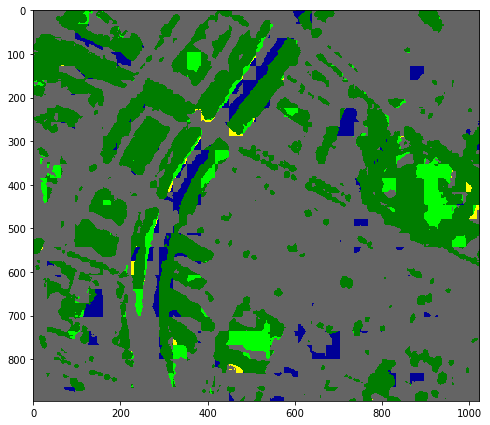

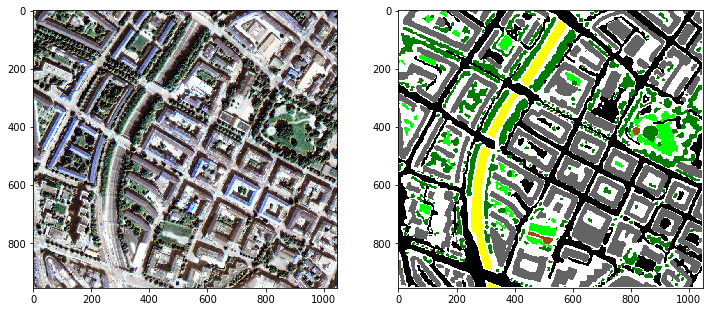

In [9]:
img_idx = 2

img = convert_patches_to_image(dataset_val.imgs, pred_labels_val[..., np.newaxis], img_idx, patch_size, patch_size, 0)

# pred
plt.figure(figsize=(8, 8))
plt.imshow(gt_label_to_color(img[...,0], dataset_val.colors)*255)
plt.show()

# im
fig, axes = plt.subplots(1, 2, figsize=(12,7))
axes[0].imshow(dataset_val.imgs[img_idx][..., :3])
axes[1].imshow(gt_label_to_color(dataset_val.gt[img_idx], dataset_val.colors)*255)
plt.show()

In [10]:
# TODO get weights
p = [p for p in model.parameters()]
for p_ in p:
    print(p_.cpu().detach().numpy().shape)

(32, 4, 3, 3)
(32,)
(32,)
(32,)
(64, 32, 3, 3)
(64,)
(64,)
(64,)
(128, 64, 3, 3)
(128,)
(128,)
(128,)
(256, 128, 3, 3)
(256,)
(256,)
(256,)
(484, 484, 1, 1)
(484,)
(9, 484, 1, 1)
(9,)
(484, 484, 1, 1)
(484,)


In [11]:
ones = np.ones(len(np.unique(dataset_train.gt_patches)))
ones[0] = 0
weight = torch.from_numpy(ones).float().cuda()
f_loss = nn.CrossEntropyLoss(weight=weight)
p = test(model, f_loss, dataloader_train, "Train", verbosity=1)
p = test(model, f_loss, dataloader_val, "Val", verbosity=1)
p = test(model, f_loss, dataloader_test, "Test", verbosity=1)

Train set: Average loss: 0.0158, Accuracy: 82.95%
Val set: Average loss: 0.0159, Accuracy: 82.47%
Test set: Average loss: 0.0164, Accuracy: 74.96%


In [12]:
# class names and colors
names = dataset_train.names
colors = dataset_train.colors
n_classes = 9
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])
names_keep = np.asarray(names)[classes_to_keep]
print("classes to keep: " + str(names_keep))

classes to keep: ['Buildings' 'Trees' 'Grass' 'Bare Soil' 'Water' 'Railways'
 'Swimming Pools']


In [13]:
# Accuracy measures for each class
y_preds = [pred_labels_tr, pred_labels_val, pred_labels_te]
datasets = [dataset_train, dataset_val, dataset_test]

aa_sets, oa_sets = [], []
for y_pred, y_true in zip(y_preds, datasets):
    y_pred_flattened = np.asarray(y_pred.flatten()).astype('int') 
    y_true_flattened = np.asarray(y_true.gt_patches.flatten()).astype('int') 

    # mask background and removed classes for evaluation metrics
    filter_items = (y_true_flattened != 0) & (y_true_flattened != class_to_remove)

    # Class accuracy, average accuracy
    #print(metrics.classification_report(y_true_flattened[filter_items], y_pred_flattened[filter_items],
    #                                    target_names=names_keep, digits=3))
    
    aa_set, _ = aa(y_true_flattened[filter_items], y_pred_flattened[filter_items])
    oa_set = oa(y_true_flattened[filter_items], y_pred_flattened[filter_items])
    print("OA: %.3f, AA: %.3f" % (oa_set, aa_set))  # slightly higher accuracy because of overlapping patches
    oa_sets.append(oa_set)
    aa_sets.append(aa_set)

OA: 0.842, AA: 0.766
OA: 0.858, AA: 0.625
OA: 0.768, AA: 0.726


In [14]:
# TODO save CSV
# write metrics to CSV files
df_metrics = pd.read_csv('models/metrics_ND.csv', index_col=0)
accs = np.concatenate([[oa_sets[i], aa_sets[i]] for i in range(3)])  # [oa, aa] for tr, val, te
df2 = pd.DataFrame({str(names[class_to_remove]):accs},
                    index = ['OA Train', 'AA Train', 'OA Val', 'AA Val', 'OA Test', 'AA Test']).T
df_metrics = df_metrics.append(df2)
df_metrics = df_metrics[~df_metrics.index.duplicated(keep='last')]  # avoid duplicates
df_metrics.to_csv('models/metrics_ND.csv')
print((df_metrics*100).round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  OA Train &  AA Train &  OA Val &  AA Val &  OA Test &  AA Test \\
\midrule
Buildings &     79.88 &     77.18 &   81.76 &   80.09 &    77.80 &    80.89 \\
Roads     &     84.19 &     76.60 &   85.79 &   62.46 &    76.84 &    72.61 \\
\bottomrule
\end{tabular}



# Retrieve Activations, Novelty Detection

In [15]:
# retrieve activations

In [31]:
def get_activations(model, dataloader_pred):
    model.get_activations = True
    with torch.no_grad():
        model.eval()
        test_pred = torch.FloatTensor()
        for i_batch, (im, gt) in tqdm(enumerate(dataloader_pred)):
            im = im.cuda()
            gt = gt.cuda()
            output = model(im)
            test_pred = torch.cat((test_pred, output.cpu()), dim=0)  # TODO change to append to optimize memory usage
    model.get_activations = False
    test_pred = test_pred.numpy()
    test_pred = np.transpose(test_pred, (0, 2, 3, 1))
    return test_pred

In [32]:
a = get_activations(model, dataloader_val_overlap)



0it [00:00, ?it/s]

1it [00:00,  1.20it/s]

2it [00:01,  1.01it/s]

3it [00:03,  1.08s/it]

4it [00:05,  1.28s/it]

5it [00:06,  1.40s/it]

6it [00:09,  1.54s/it]

7it [00:11,  1.68s/it]

8it [00:16,  2.07s/it]

9it [00:22,  2.52s/it]

10it [00:26,  2.68s/it]

11it [00:31,  2.84s/it]

12it [00:36,  3.03s/it]

13it [00:41,  3.22s/it]

14it [00:48,  3.44s/it]

15it [00:55,  3.67s/it]

16it [01:02,  3.90s/it]

17it [01:10,  4.13s/it]

18it [01:18,  4.36s/it]

19it [01:27,  4.58s/it]

20it [01:35,  4.79s/it]

21it [01:45,  5.03s/it]

22it [01:56,  5.29s/it]

23it [02:06,  5.52s/it]

24it [02:18,  5.77s/it]

25it [02:30,  6.01s/it]

26it [02:42,  6.25s/it]

27it [02:55,  6.50s/it]

28it [03:09,  6.78s/it]

29it [03:25,  7.09s/it]

30it [03:40,  7.36s/it]

31it [03:56,  7.64s/it]

32it [04:14,  7.94s/it]

33it [04:32,  8.25s/it]

34it [04:50,  8.56s/it]

35it [05:11,  8.91s/it]

36it [05:36,  9.35s/it]

37it [05:57,  9.67s/it]

38it [06:22, 10.07s/it]

39it [06:48, 10.47s/it]

40it [07:18,

In [33]:
a.shape

(4688, 64, 64, 484)

In [37]:
a = remove_overlap(dataset_val.imgs, a, np.arange(5), patch_size=patch_size, stride=int(patch_size/2))
a = np.concatenate(a)

## PCA

In [48]:
a_flat = np.concatenate(np.concatenate(a))

In [49]:
a_flat.shape

(4800512, 484)

In [40]:
# python libraries
import os, sys
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
from sklearn import decomposition, svm, preprocessing
from sklearn.utils import class_weight
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics

# custom libraries
from helpers.parameter_search import *
from density_forest.density_forest import *
from density_forest.plots import *
from density_forest.helpers import *

Using TensorFlow backend.


In [53]:
np.shape(draw_subsamples(a_flat, .001))

(4801, 484)

In [54]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)
pca.fit(draw_subsamples(a_flat, .001))  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

Variance explained by first 52 components: 0.95


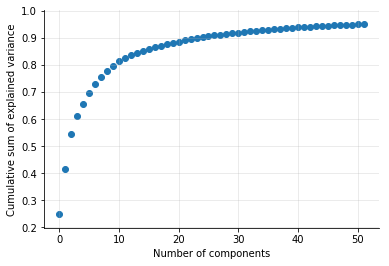

In [55]:
# Plot cumulative explained variance
fig = plt.figure()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.savefig("Figures/pca_components_wo_cl_" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [ ]:
# solution: have less filters in the end to force them to capture information in little space!

In [ ]:
# transform training activations
act_train_all = pca.transform(np.concatenate(np.concatenate(act_train_all)))
act_train = pca.transform(act_train)

act_val_all = pca.transform(np.concatenate(np.concatenate(act_val_all)))
act_val = pca.transform(act_val)


# transform test set activations
act_test = pca.transform(act_test)